In [27]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

## 1. Basic autograd example

In [2]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

In [3]:
y = w * x + b 

In [4]:
y.backward()

In [5]:
print(x.grad)
print(w.grad)
print(b.grad)

tensor(2.)
tensor(1.)
tensor(1.)


## 2. Basic autograd example 2 

In [14]:
x = torch.randn(10, 3).cuda()
y = torch.randn(10, 2).cuda()

linear = nn.Linear(3, 2).cuda()
print('w: ', linear.weight)
print('b: ', linear.bias)

criterion = nn.MSELoss().cuda()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

pred = linear(x)
loss = criterion(pred, y)
print('loss: ', loss.item())

loss.backward()

print('dL/dw: ',linear.weight.grad)
print('dL/db: ', linear.bias.grad)
# 1-step gradient descent
optimizer.step()

# You can also perform gradient descent at the low level.
# linear.weight.data.sub_(0.01 * linear.weight.grad.data)
# linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent 
pred = linear(x)
loss = criterion(pred, y)
print('loss after 1 step optimization: ', loss.item())

w:  Parameter containing:
tensor([[-0.2193, -0.4749,  0.5237],
        [ 0.3885,  0.4380,  0.4996]], device='cuda:0', requires_grad=True)
b:  Parameter containing:
tensor([-0.4298,  0.0819], device='cuda:0', requires_grad=True)
loss:  2.5752384662628174
dL/dw:  tensor([[-0.3993, -0.6786,  0.3169],
        [ 0.5113,  0.7795,  1.4789]], device='cuda:0')
dL/db:  tensor([-1.1608,  1.1440], device='cuda:0')
loss after 1 step optimization:  2.5113987922668457


## 3.Loading data from numpy

In [2]:
# 创建一个numpy矩阵
x = np.array([[1, 2],[3, 4]])

#将numpy矩阵转为torch张量
y = torch.from_numpy(x).cuda()

#将torch张量转为numpy矩阵
z = y.cpu().numpy()

##  Input pipeline

In [4]:
# 下载和构造 CIFRA-10 数据集
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=True,
                                            transform=transforms.ToTensor(),
                                            download=True)

Files already downloaded and verified


In [8]:
# 获取数据集中的一对数据（从本地磁盘中获取数据）
image, label = train_dataset[32]
print(image.size())
print(type(image))
print(label)
print(type(label))

torch.Size([3, 32, 32])
<class 'torch.Tensor'>
1
<class 'int'>


torch.Size([3, 32, 32])


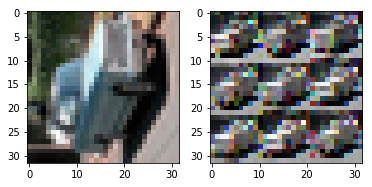

In [9]:
#显示这一对数据看看~
import matplotlib.pyplot as plt
img = image.numpy()
print(image.shape)
#数据为(3 ,32 ,32)，尝试两种方法来转为(32, 32, 3)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.swapaxes(img, 0, 2))#尝试第一种方法，正确！
plt.subplot(1,2,2)
plt.imshow(img.reshape(32,32,3))#尝试第二种方法，错了
plt.show()

In [11]:
# 使用数据生成器（DataLoader）
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)

In [13]:
#当迭代开始时，队列和线程开始从文件（数据集）中加载数据
data_iter = iter(train_loader)

# 一个batch
images, labels = data_iter.next()

print(images.size())

torch.Size([64, 3, 32, 32])


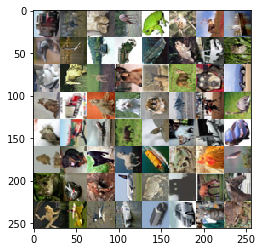

In [15]:
pic = np.zeros((32*8, 32*8, 3))
row = 0
col = 0
row_flag = 0
col_flag = 0
i = 0
for image, label in zip(images, labels):
    # 训练代码写此处
    img = np.swapaxes(image.numpy(), 0, 2)
    #print(image.shape)
    #break
    pic[row*32:(row+1)*32, col*32:(col+1)*32, :] = img
    i += 1
    if i!= 8:#画图次数
        col += 1
    else:
        row += 1
        col = 0
        i = 0
        
    # pass
plt.imshow(pic)
plt.show()

## Input pipelines for custom dataset

In [16]:
# 构建自定义的数据集，应该以如下格式：
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self):
        # TODO(代办事项)
        # 构建初始化文件路径 或者 文件名列表
        pass
    def __getitem__(self, index):
        # TODO
        # 1. 从文件中读取一个数据 (e.g. using numpy.formfile, PIL.Image.open)
        # 2. 对这个数据进行预处理 (e.g. torchvision.Transform)
        # 3. 返回数据对 (e.g. image and label)
        pass
    def __len__(self):
        # 这里应该改变0为我的数据集的整个的大小
        return 0

In [17]:
# 我可以使用预创建的数据生成器(DataLoader)
custom_dataset = CustomDataset()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                          batch_size=64,
                                          shuffle=True)

#### [实例1参考链接](https://pytorch.org/docs/master/_modules/torchvision/datasets/mnist.html#FashionMNIST)
以下是自定义数据集实例1:

In [ ]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import gzip
import numpy as np
import torch
import codecs
from .utils import download_url, makedir_exist_ok


class MNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return os.path.exists(os.path.join(self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.processed_folder, self.test_file))

    @staticmethod
    def extract_gzip(gzip_path, remove_finished=False):
        print('Extracting {}'.format(gzip_path))
        with open(gzip_path.replace('.gz', ''), 'wb') as out_f, \
                gzip.GzipFile(gzip_path) as zip_f:
            out_f.write(zip_f.read())
        if remove_finished:
            os.unlink(gzip_path)

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        makedir_exist_ok(self.raw_folder)
        makedir_exist_ok(self.processed_folder)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.raw_folder, filename)
            download_url(url, root=self.raw_folder, filename=filename, md5=None)
            self.extract_gzip(gzip_path=file_path, remove_finished=True)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str



class FashionMNIST(MNIST):
    """`Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
    ]
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [45]:
from PIL import Image
# 直接丢链接用迅雷下的，所以得使用源码，供于学习
# from __future__ import print_function
# import torch.utils.data as data
# from PIL import Image
# import os
# import os.path
# import gzip
# import numpy as np
# import torch
# import codecs
# def get_int(b):
#     return int(codecs.encode(b, 'hex'), 16)

# def read_label_file(path):
#     with open(path, 'rb') as f:
#         data = f.read()
#         assert get_int(data[:4]) == 2049
#         length = get_int(data[4:8])
#         parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
#         return torch.from_numpy(parsed).view(length).long()


# def read_image_file(path):
#     with open(path, 'rb') as f:
#         data = f.read()
#         assert get_int(data[:4]) == 2051
#         length = get_int(data[4:8])
#         num_rows = get_int(data[8:12])
#         num_cols = get_int(data[12:16])
#         parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
#         return torch.from_numpy(parsed).view(length, num_rows, num_cols)

#     print('Processing...')
# raw_folder = '../../data/fashion/raw'
# training_file = 'training.pt'
# test_file = 'test.pt'
# processed_folder = '../../data/fashion/processed'

# training_set = (
#             read_image_file(os.path.join(raw_folder, 'train-images-idx3-ubyte')),
#             read_label_file(os.path.join(raw_folder, 'train-labels-idx1-ubyte'))
#         )
# test_set = (
#             read_image_file(os.path.join(raw_folder, 't10k-images-idx3-ubyte')),
#             read_label_file(os.path.join(raw_folder, 't10k-labels-idx1-ubyte'))
#         )
# with open(os.path.join(processed_folder, training_file), 'wb') as f:
#             torch.save(training_set, f)
# with open(os.path.join(processed_folder, test_file), 'wb') as f:
#             torch.save(test_set, f)
# print('Done!')
pretrained_dataset = torchvision.datasets.FashionMNIST('../../data/fashion', train=True, transform=None, target_transform=None, download=False)
#如果要想MNIST一样，则用transform=transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(dataset=pretrained_dataset,
                                          batch_size=1,
                                          shuffle=True)

In [46]:
image, label = pretrained_dataset[32]
print(type(image))
print(type(label))

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>


In [48]:
from PIL import Image
pretrained_dataset = torchvision.datasets.FashionMNIST('../../data/fashion', train=True, transform=np.asarray, target_transform=None, download=False)

train_loader = torch.utils.data.DataLoader(dataset=pretrained_dataset,
                                          batch_size=1,
                                          shuffle=True)

img.shape:  (28, 28)


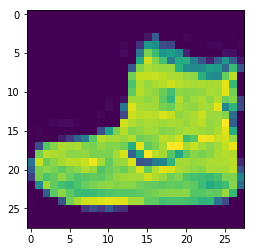

target:  9


In [54]:
import matplotlib.pyplot as plt
img, label = pretrained_dataset[0]
print('img.shape: ',img.shape)
plt.figure()
plt.imshow(img)#尝试第二种方法，错了
plt.show()
print('target: ', label.numpy())

#### [实例2参考链接](https://blog.csdn.net/u012684062/article/details/78547505)
以下是自定义数据集实例2：

In [ ]:
class MyTrainData(torch.utils.data.Dataset):
    def __init__(self):
        self.video_path = '/data/FrameFeature/Penn/'
        self.video_file = '/data/FrameFeature/Penn_train.txt'
        fp = open(self.video_file,'r')
        lines = fp.readlines()
        fp.close()
        self.video_name = []
        for line in lines:
            self.video_name.append(line.strip().split(' ')[0])
    def __len__(self):
        return len(self.video_name)
    def __getitem__(self, index):
        data = load_feature(os.path.join(self.video_path,self.video_name[index]))
        data = np.expand_dims(data,2)
        return data

custom_dataset = CustomDataset()
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                          batch_size=1,
                                          shuffle=True)

## Pretrained Model

In [56]:
#Download and load the pretrained Resnet-18
resnet = torchvision.models.resnet18(pretrained=True).cuda()
# 保存和加载整个模型
torch.save(resnet, 'model_ch1.ckpt')
model = torch.load('model_ch1.ckpt')

In [57]:
# 仅保存和加载 模型的参数（推荐）
torch.save(resnet.state_dict(), 'params.ckpt')
resnet.load_state_dict(torch.load('params.ckpt'))